In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time,copy

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

## Estimation of the size of the electron cloud in the z direction

In [2]:
D_L = 25.0 #cm^2/s
t_d = 77.0/1.e6 #s
v_d = 14.0/t_d #cm/s
two_sigma = 2*np.sqrt(2*D_L*t_d)
time_spread = 2*two_sigma/v_d
time_spread_us = time_spread*1.e6
print('99% of the charge cloud collected in {:.1f}us'.format(time_spread_us))

99% of the charge cloud collected in 1.4us


In [3]:
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
path_to_reduced = '/p/lustre1/jacopod/29th/analysis_500ns/'
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff


In [4]:
folder = '20200213_AfterRnInjection'
df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
Til

In [48]:
energy_min = 200
energy_max  = 7000
t_min = 10
t_max = 70
df = df[df['NumTileChannelsHit']==1]

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


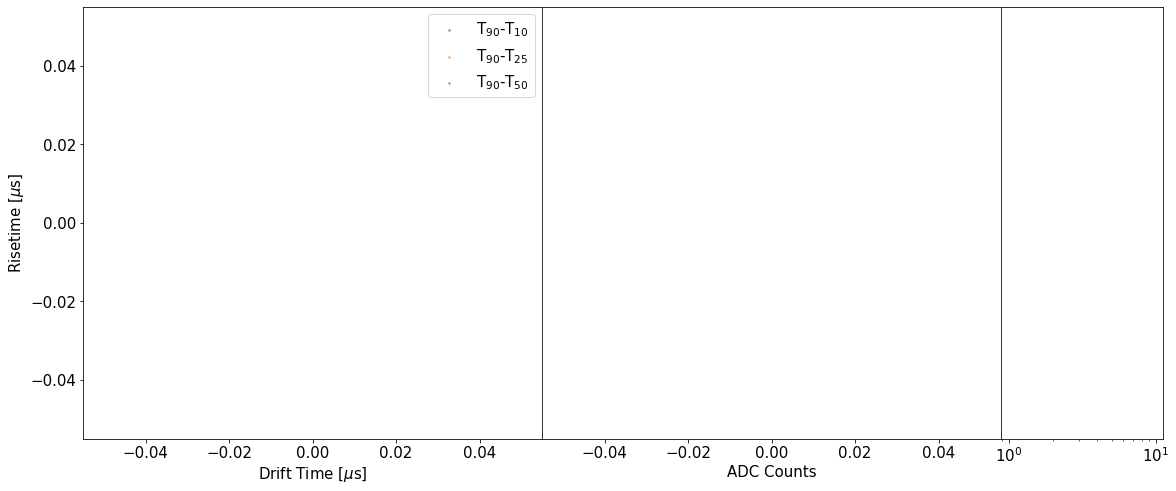

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


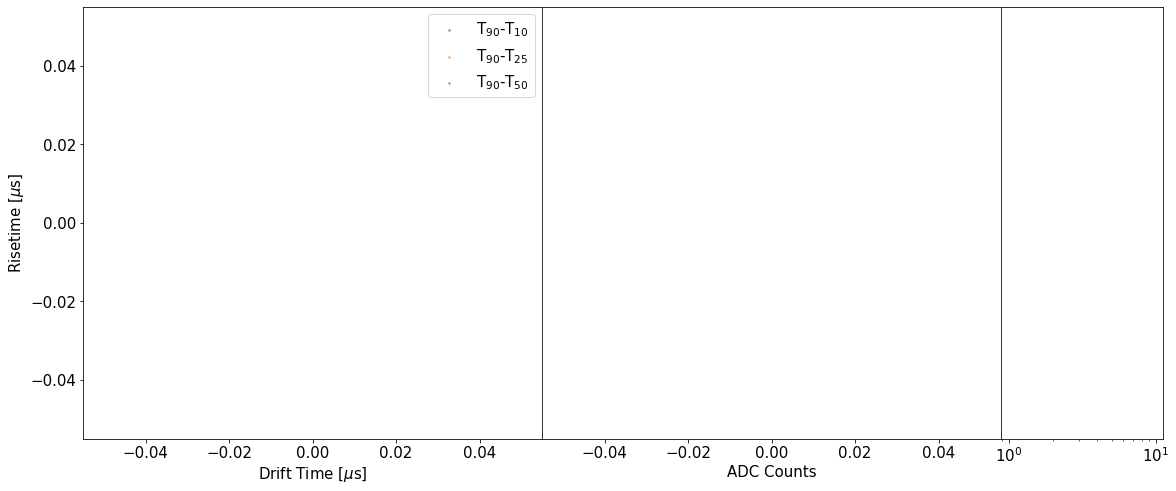

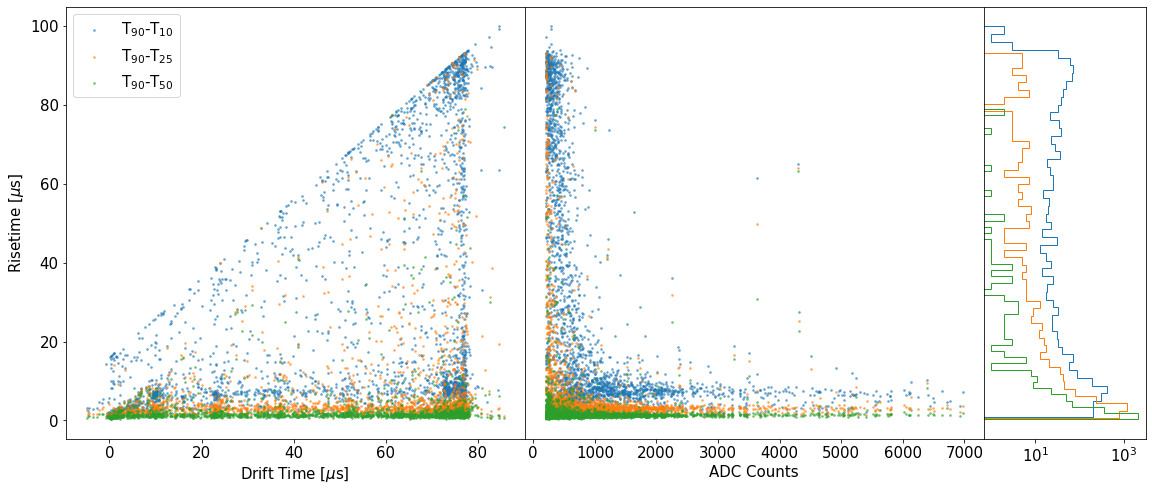

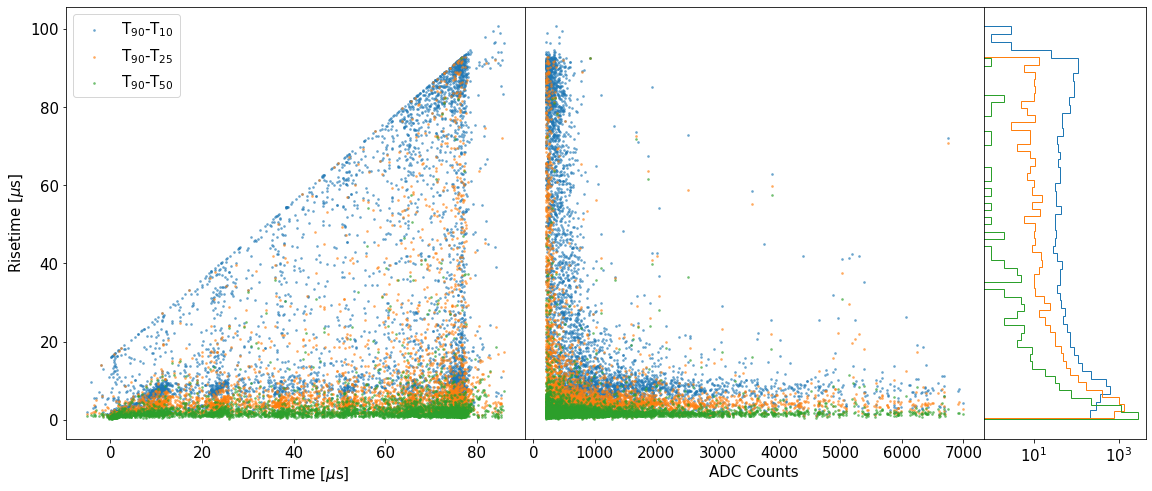

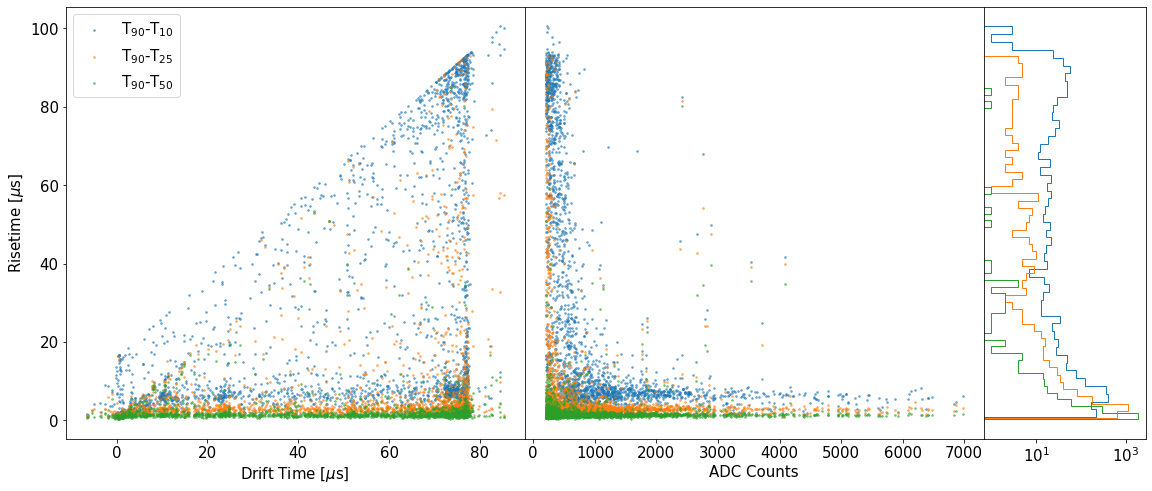

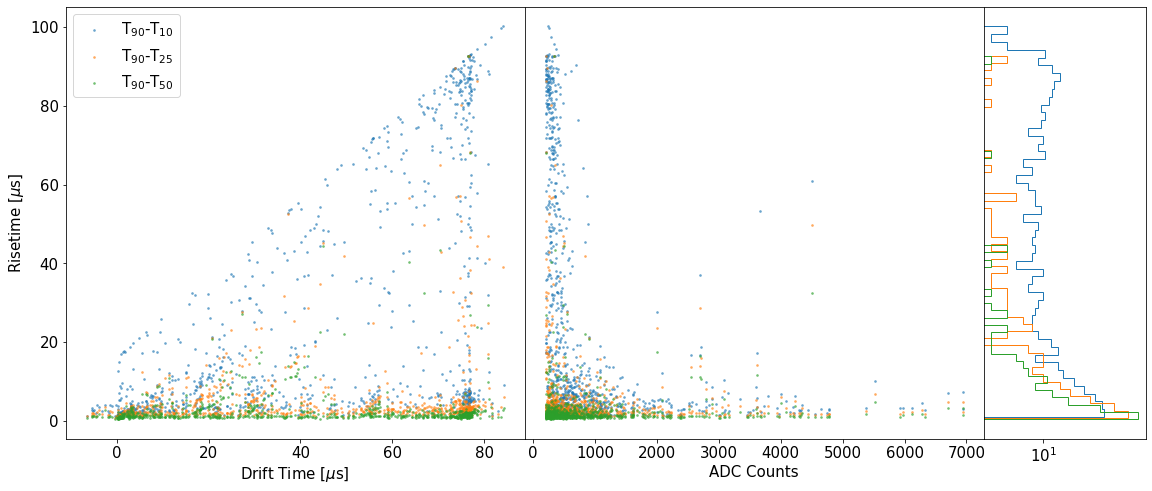

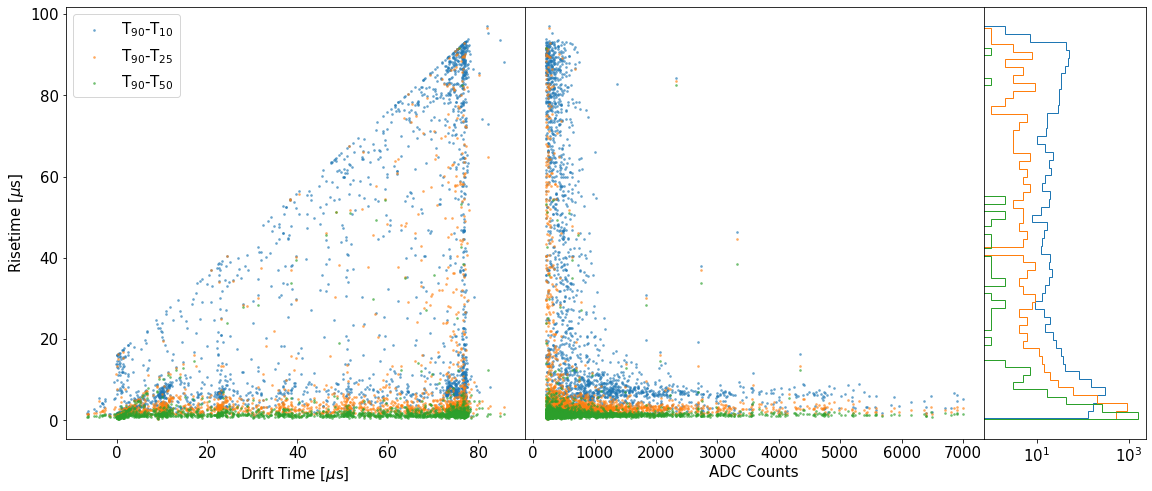

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


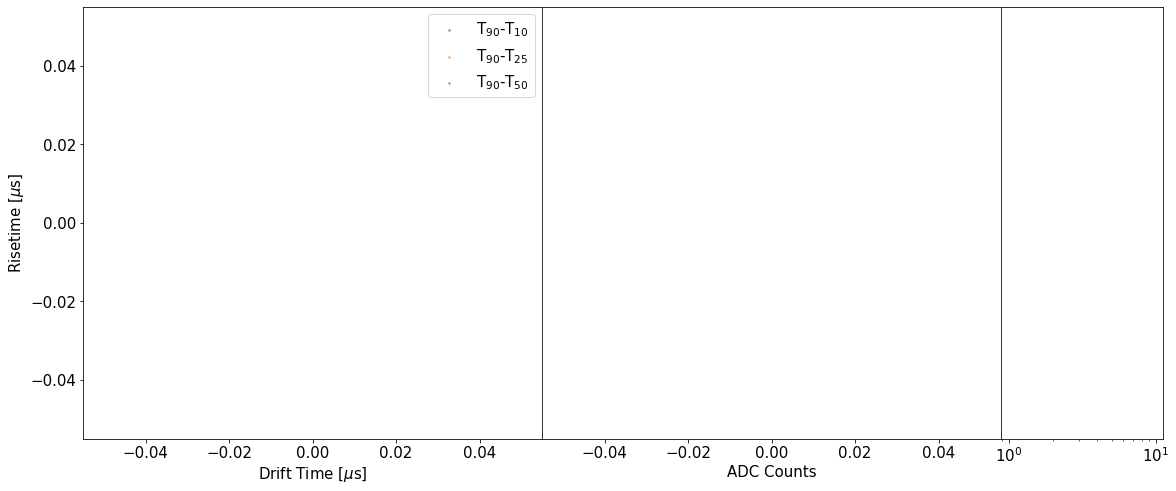

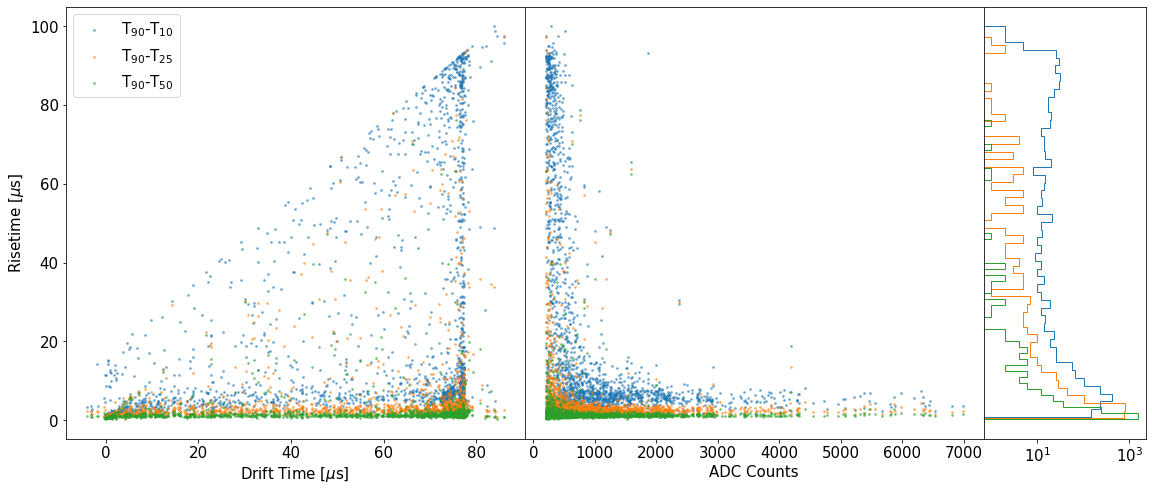

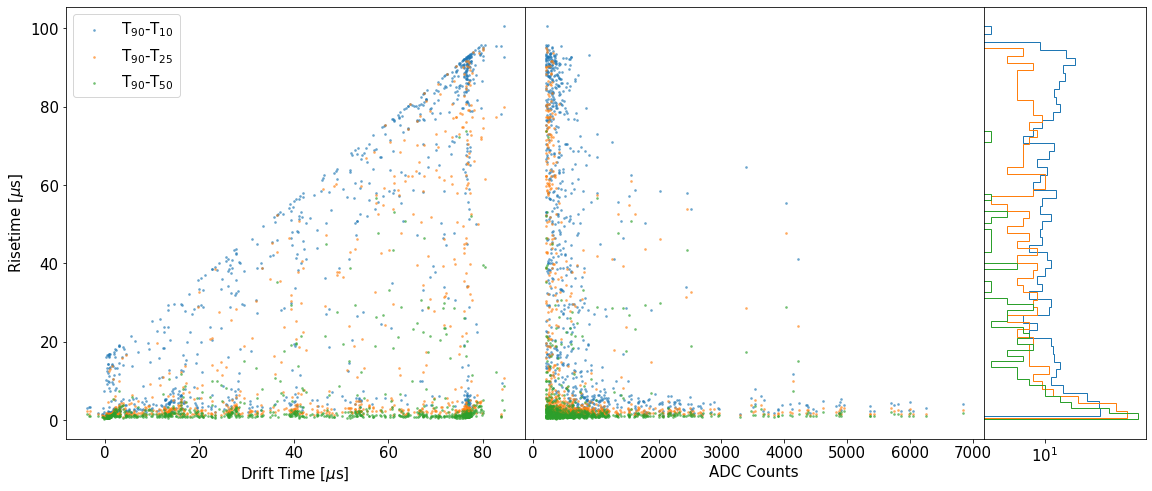

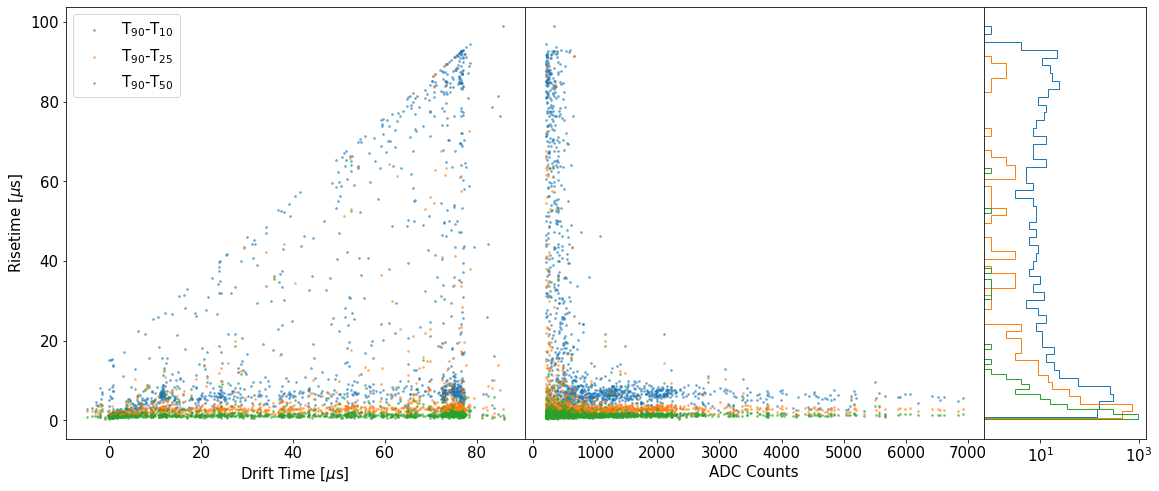

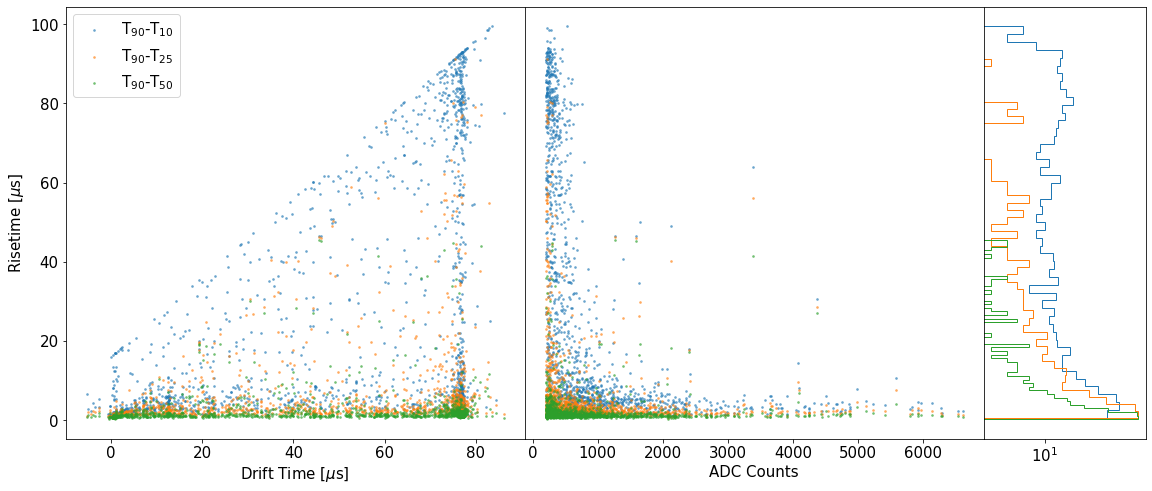

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


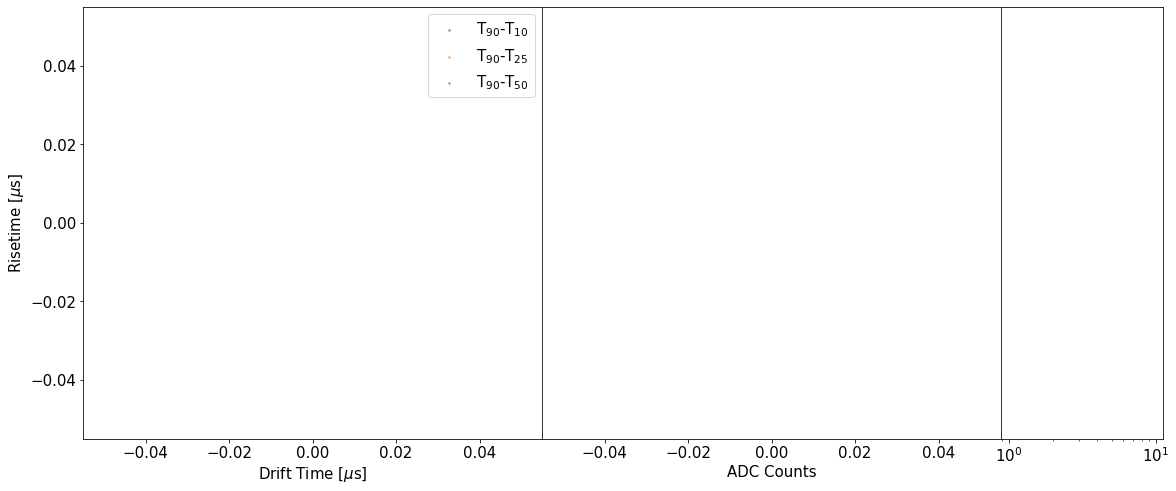

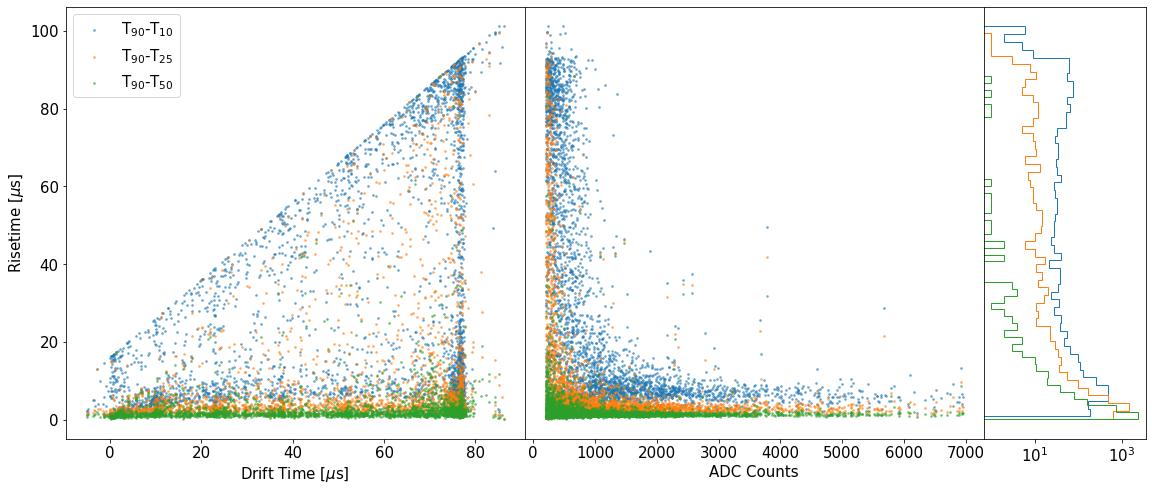

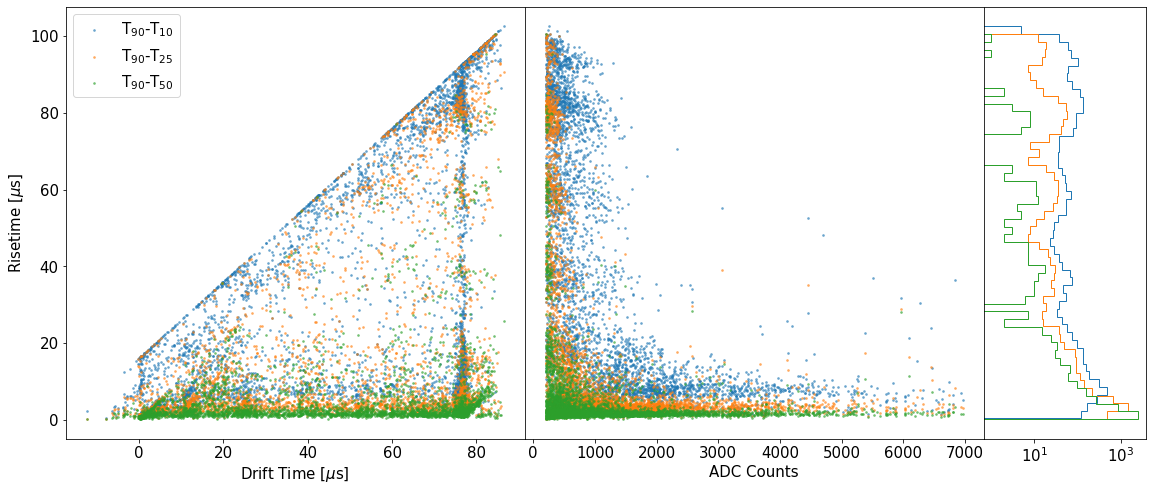

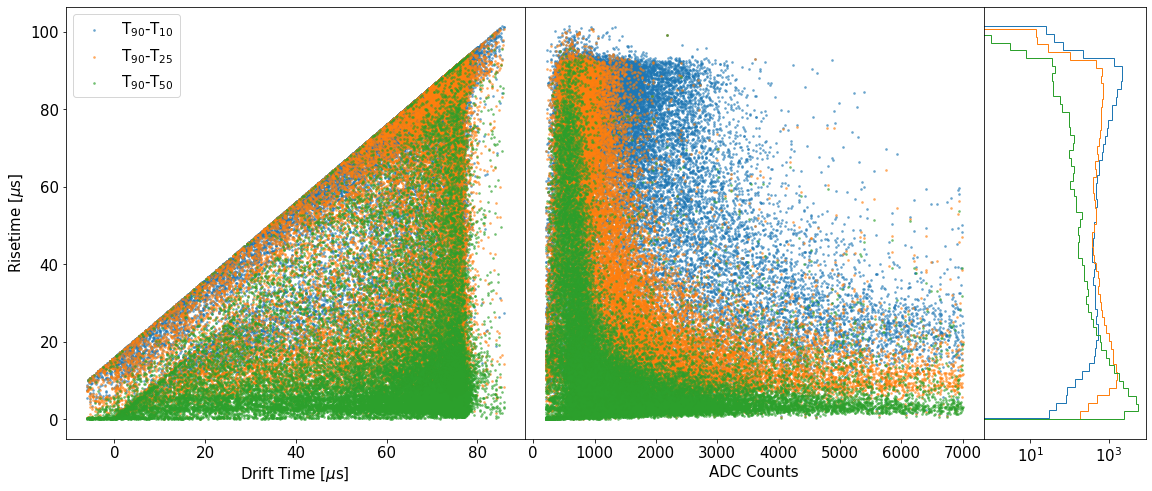

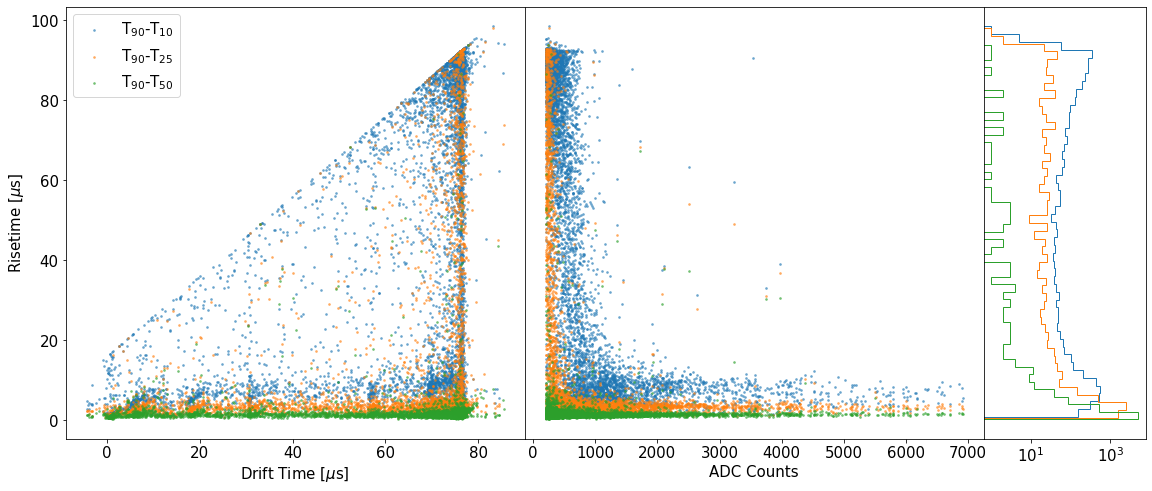

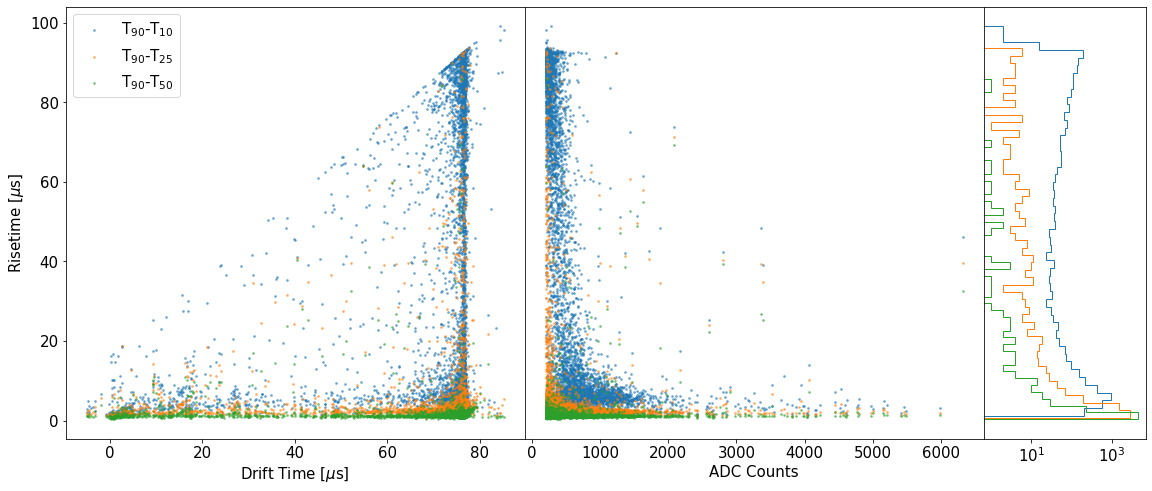

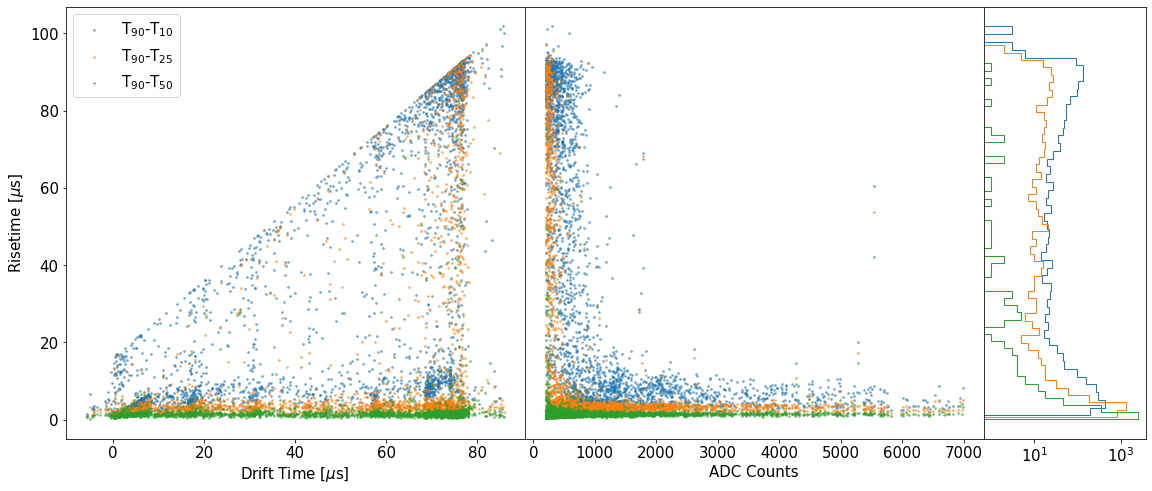

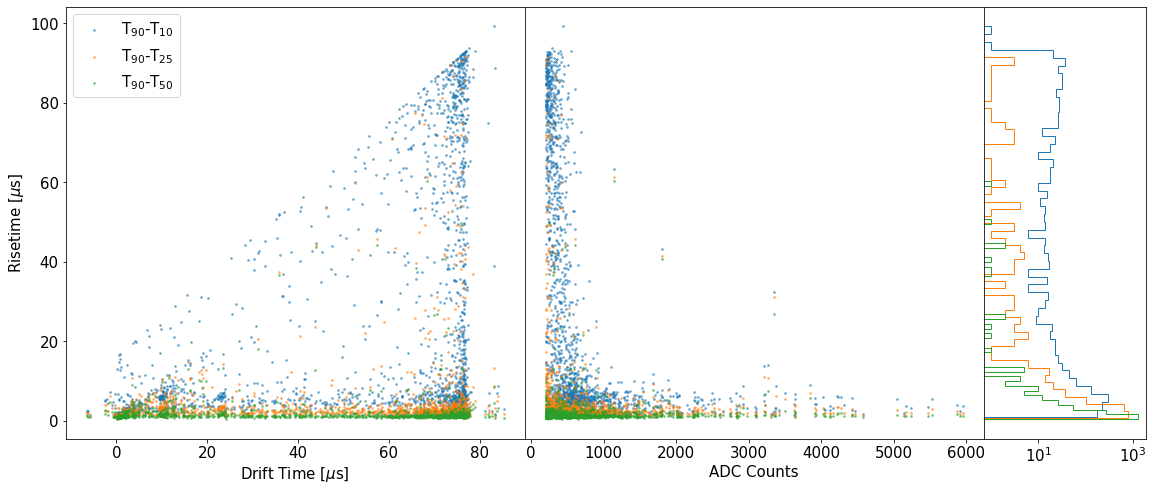

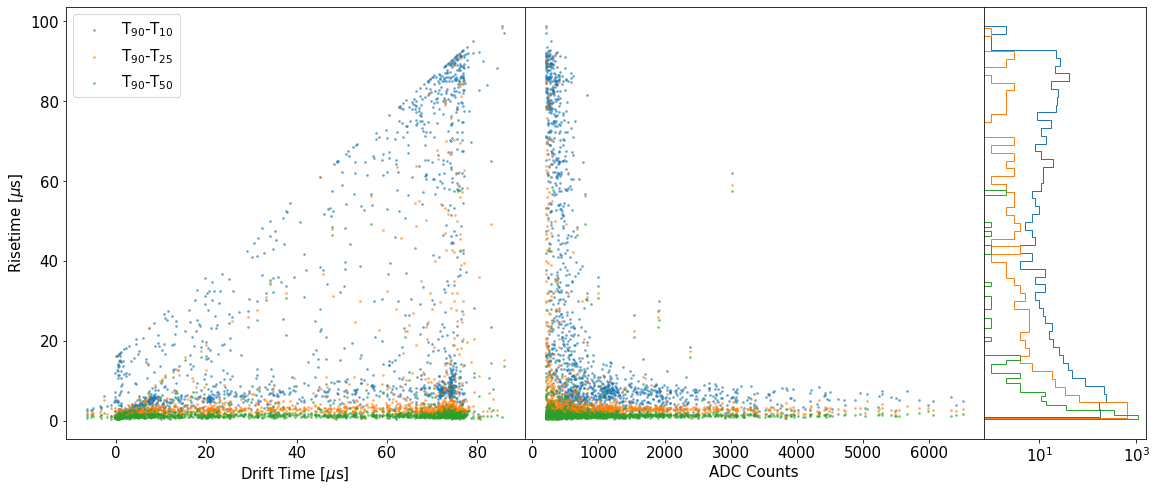

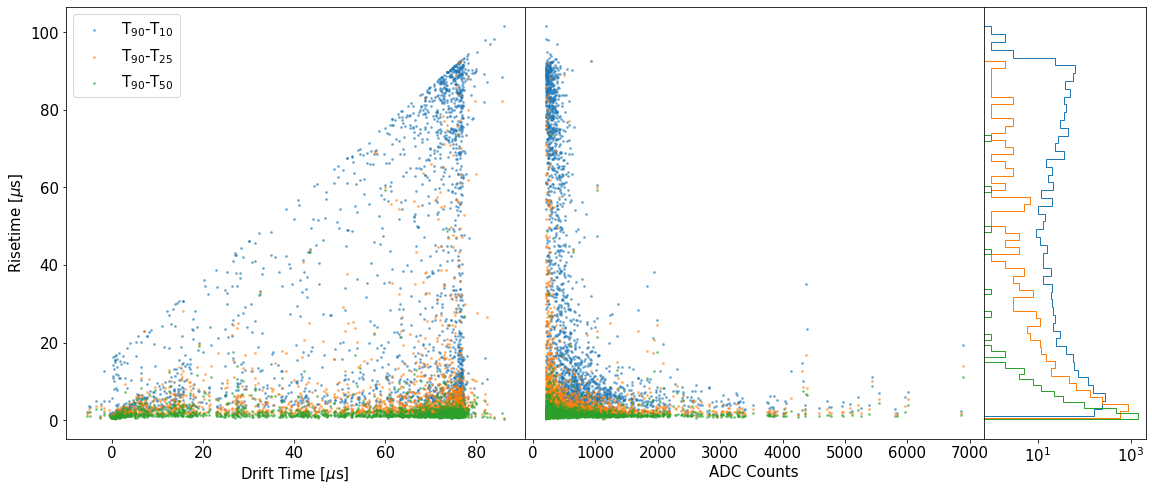

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


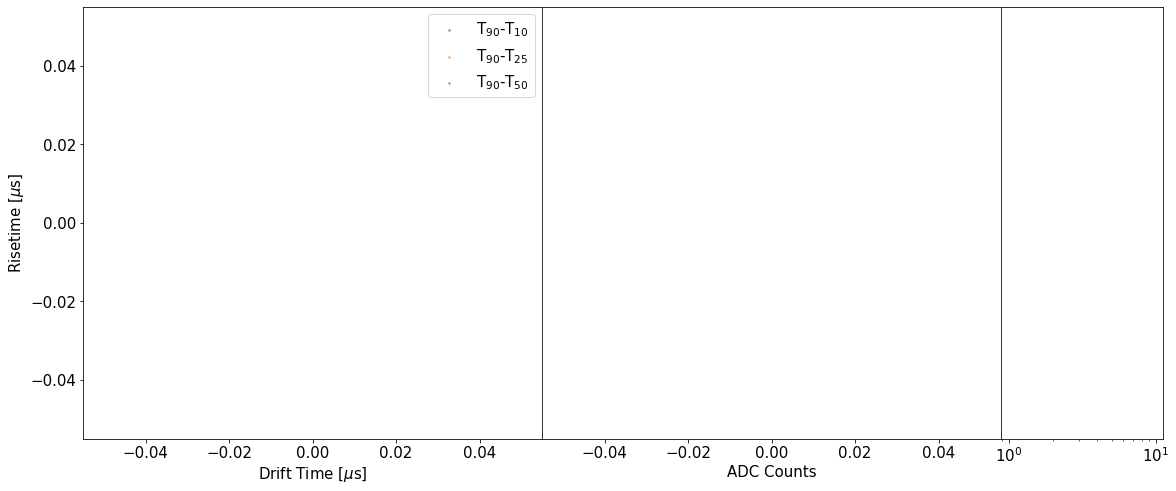

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


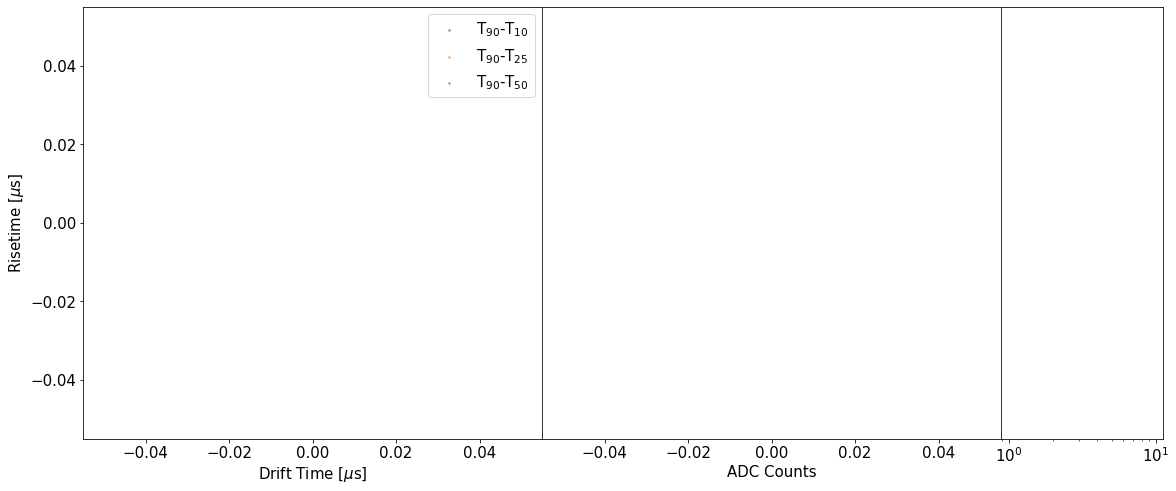

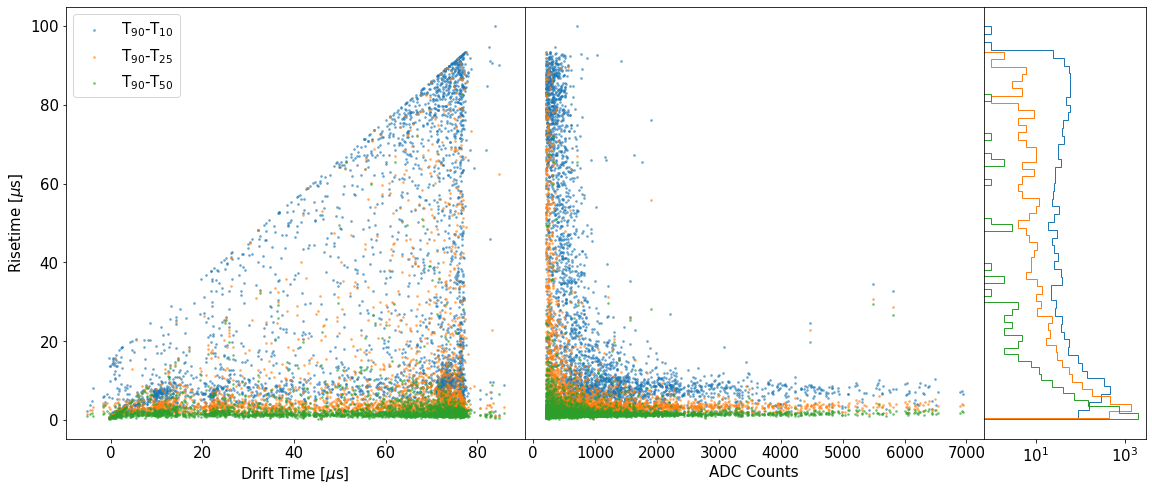

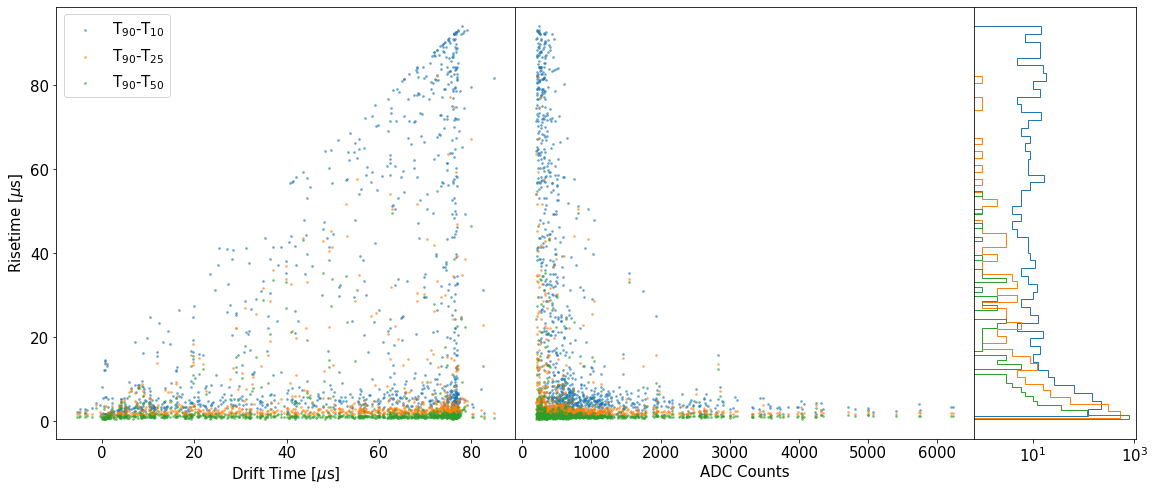

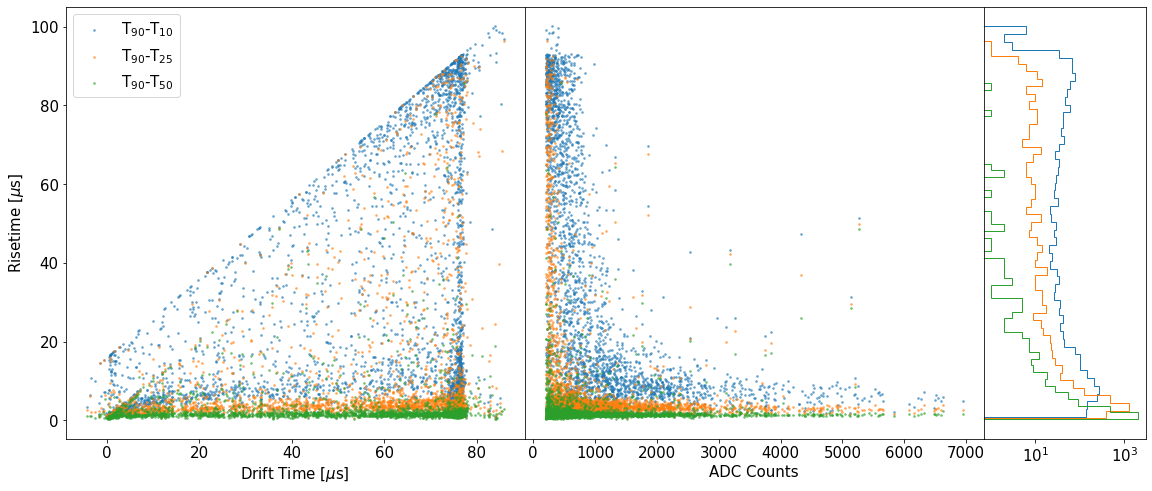

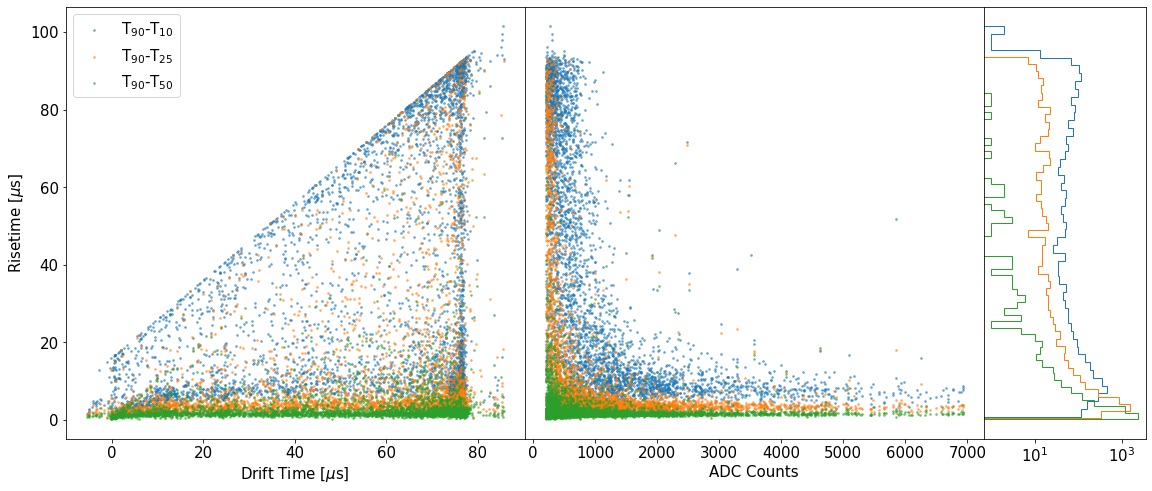

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


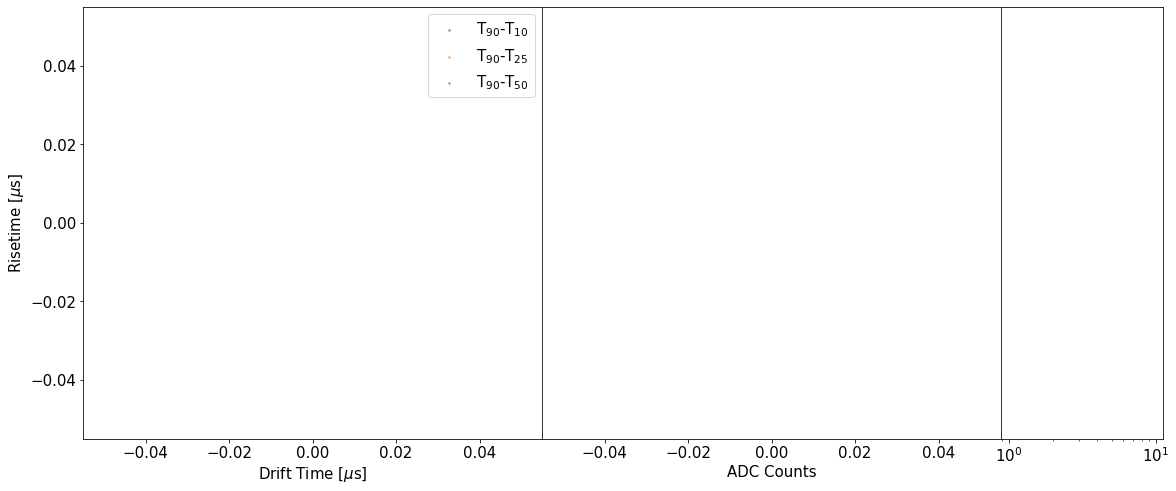

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


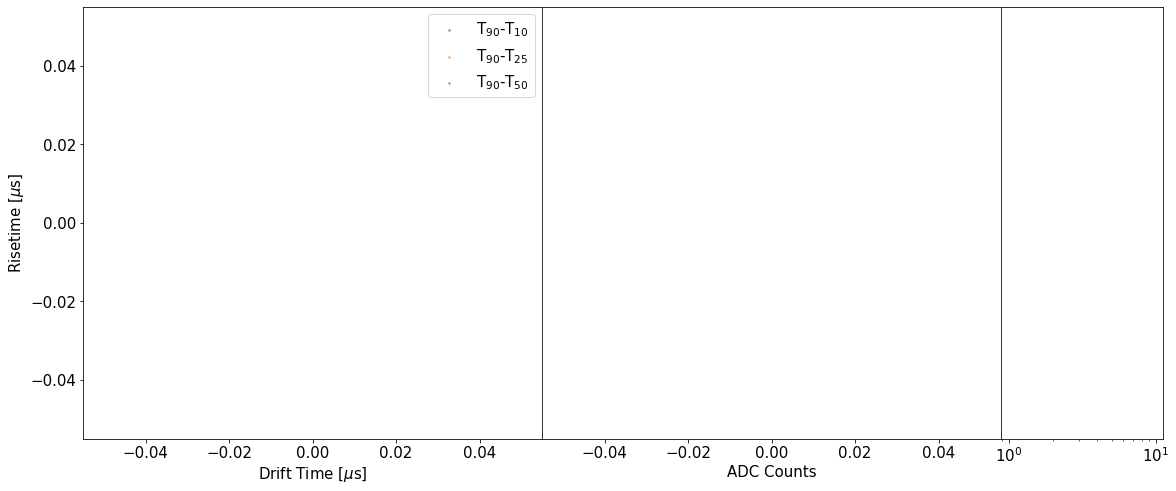

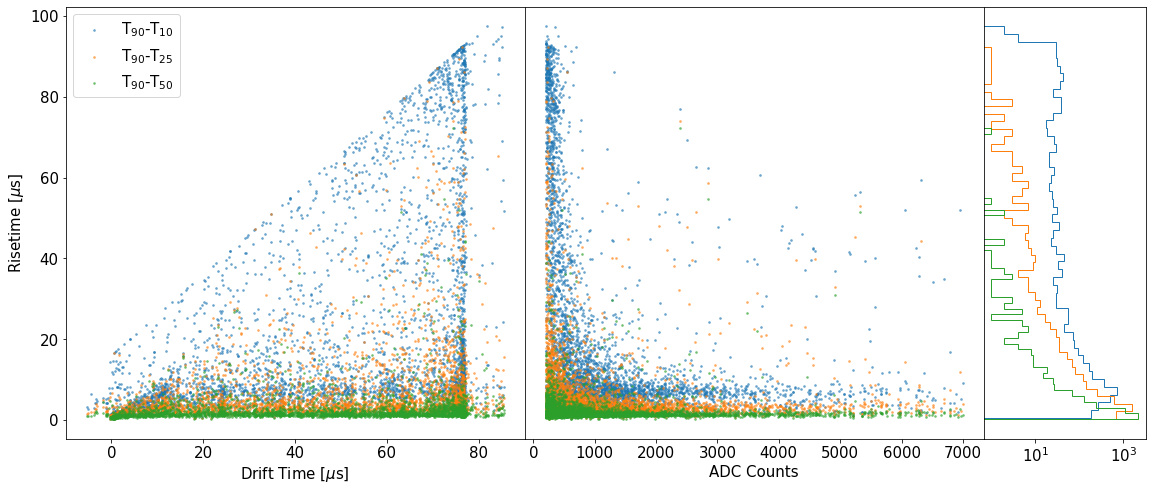

In [49]:
i = 0
bins = 50
analysis_config.GetCalibrationConstantsFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv')
for k in df.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    fig,ax = plt.subplots(1,3,figsize=(15,6))
    ch_name = analysis_config.calibration_constants.index[i]
    ch = 'TileStrip ' + ch_name
    i += 1
    mask = np.logical_and(df[ch + ' Charge Energy']>energy_min,df[ch + ' Charge Energy']<energy_max)
    rise_time10 = (df[ch + ' T90'][mask] - df[ch + ' T10'][mask])*sampling_time
    rise_time25 = (df[ch + ' T90'][mask] - df[ch + ' T25'][mask])*sampling_time
    rise_time50 = (df[ch + ' T90'][mask] - df[ch + ' T50'][mask])*sampling_time
    rise_time1025 = (df[ch + ' T25'][mask] - df[ch + ' T10'][mask])*sampling_time
    rise_time2550 = (df[ch + ' T50'][mask] - df[ch + ' T25'][mask])*sampling_time
    rise_time5090 = (df[ch + ' T90'][mask] - df[ch + ' T50'][mask])*sampling_time
    ch_drift_time = df[ch + ' Drift Time'][mask]
    ax[0].scatter(ch_drift_time,rise_time10,s=3,alpha=0.5,label = 'T$_{90}$-T$_{10}$')
    ax[0].scatter(ch_drift_time,rise_time25,s=3,alpha=0.5,label = 'T$_{90}$-T$_{25}$')
    ax[0].scatter(ch_drift_time,rise_time50,s=3,alpha=0.5,label = 'T$_{90}$-T$_{50}$')
    ax[0].set_xlabel('Drift Time [$\mu$s]')
    ax[0].set_ylabel('Risetime [$\mu$s]')
    ax[0].set_position([0,0,0.425,1])
    ax[1].scatter(df[ch + ' Charge Energy'][mask],rise_time10,s=3,alpha=0.5,label = 'T$_{90}$-T$_{10}$')
    ax[1].scatter(df[ch + ' Charge Energy'][mask],rise_time25,s=3,alpha=0.5,label = 'T$_{90}$-T$_{25}$')
    ax[1].scatter(df[ch + ' Charge Energy'][mask],rise_time50,s=3,alpha=0.5,label = 'T$_{90}$-T$_{50}$')
    ax[1].get_yaxis().set_visible(False)
    ax[1].set_xlabel('ADC Counts')
    ax[1].set_position([0.425,0,0.425,1])
    ax[2].set_position([0.85,0,0.15,1])
    ax[2].hist(rise_time10, orientation='horizontal', bins = bins, histtype='step',log=True)
    ax[2].hist(rise_time25, orientation='horizontal', bins = bins, histtype='step',log=True)
    ax[2].hist(rise_time50, orientation='horizontal', bins = bins, histtype='step',log=True)
    ax[2].get_yaxis().set_visible(False)
    ax[0].legend()
    plt.show()

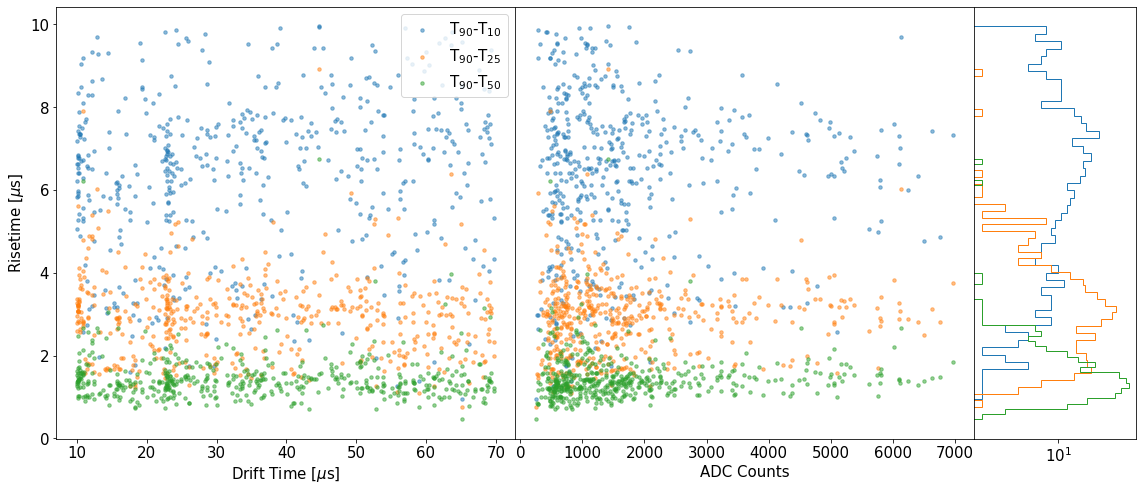

In [50]:
ch = 'TileStrip X14'
fig,ax = plt.subplots(1,3,figsize=(15,6))
mask_energy = np.logical_and(df[ch + ' Charge Energy']>energy_min,df[ch + ' Charge Energy']<energy_max)
mask_time = np.logical_and(df[ch + ' Drift Time']>t_min,df[ch + ' Drift Time']<t_max)
mask = np.logical_and(mask_energy,mask_time)
rise_time10 = (df[ch + ' T90'][mask] - df[ch + ' T10'][mask])*sampling_time
rise_time25 = (df[ch + ' T90'][mask] - df[ch + ' T25'][mask])*sampling_time
rise_time50 = (df[ch + ' T90'][mask] - df[ch + ' T50'][mask])*sampling_time
rise_time1025 = (df[ch + ' T25'][mask] - df[ch + ' T10'][mask])*sampling_time
rise_time2550 = (df[ch + ' T50'][mask] - df[ch + ' T25'][mask])*sampling_time
rise_time5090 = (df[ch + ' T90'][mask] - df[ch + ' T50'][mask])*sampling_time
ch_drift_time = df[ch + ' Drift Time'][mask]
mask_risetime = rise_time10<10
ax[0].scatter(ch_drift_time[mask_risetime],rise_time10[mask_risetime],s=12,alpha=0.5,label = 'T$_{90}$-T$_{10}$')
ax[0].scatter(ch_drift_time[mask_risetime],rise_time25[mask_risetime],s=12,alpha=0.5,label = 'T$_{90}$-T$_{25}$')
ax[0].scatter(ch_drift_time[mask_risetime],rise_time50[mask_risetime],s=12,alpha=0.5,label = 'T$_{90}$-T$_{50}$')
ax[0].set_xlabel('Drift Time [$\mu$s]')
ax[0].set_ylabel('Risetime [$\mu$s]')
ax[0].set_position([0,0,0.425,1])
ax[1].scatter(df[ch + ' Charge Energy'][mask][mask_risetime],rise_time10[mask_risetime],\
              s=12,alpha=0.5,label = 'T$_{90}$-T$_{10}$')
ax[1].scatter(df[ch + ' Charge Energy'][mask][mask_risetime],rise_time25[mask_risetime],\
              s=12,alpha=0.5,label = 'T$_{90}$-T$_{25}$')
ax[1].scatter(df[ch + ' Charge Energy'][mask][mask_risetime],rise_time50[mask_risetime],\
              s=12,alpha=0.5,label = 'T$_{90}$-T$_{50}$')
ax[1].get_yaxis().set_visible(False)
ax[1].set_xlabel('ADC Counts')
ax[1].set_position([0.425,0,0.425,1])
ax[2].set_position([0.85,0,0.15,1])
ax[2].hist(rise_time10[mask_risetime], orientation='horizontal', bins = bins, histtype='step',log=True)
ax[2].hist(rise_time25[mask_risetime], orientation='horizontal', bins = bins, histtype='step',log=True)
ax[2].hist(rise_time50[mask_risetime], orientation='horizontal', bins = bins, histtype='step',log=True)
ax[2].get_yaxis().set_visible(False)
ax[0].legend()
plt.show()

In [51]:
mask_waveform = np.logical_and(np.logical_and(ch_drift_time>20,ch_drift_time<25),\
                               np.logical_and(rise_time10>6,rise_time10<8))
selection_index = df[mask][df[ch + ' Charge Energy'][mask]>2500].index
print('selection cut: {} events'.format(selection_index.shape[0]))

selection cut: 111 events


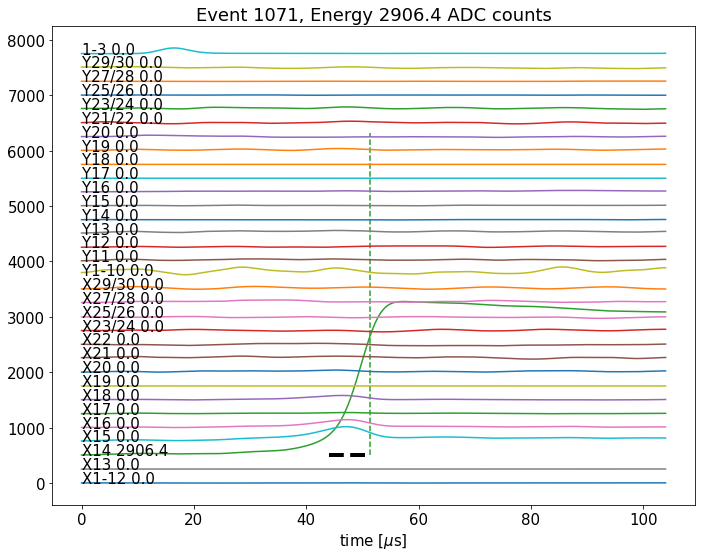

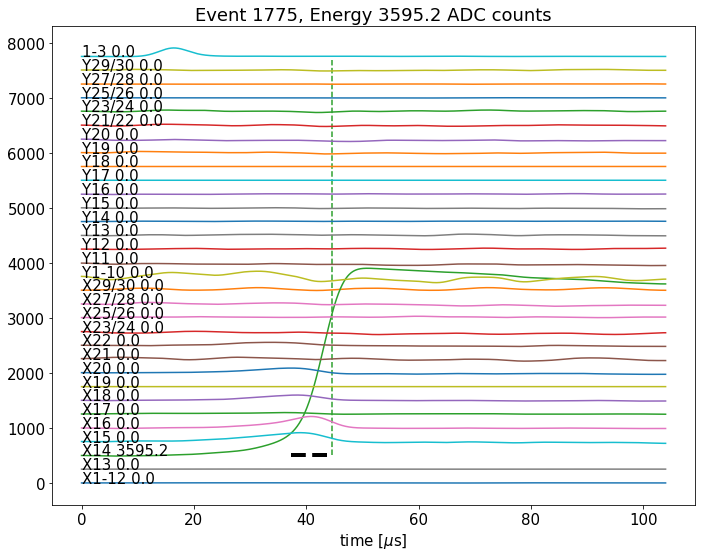

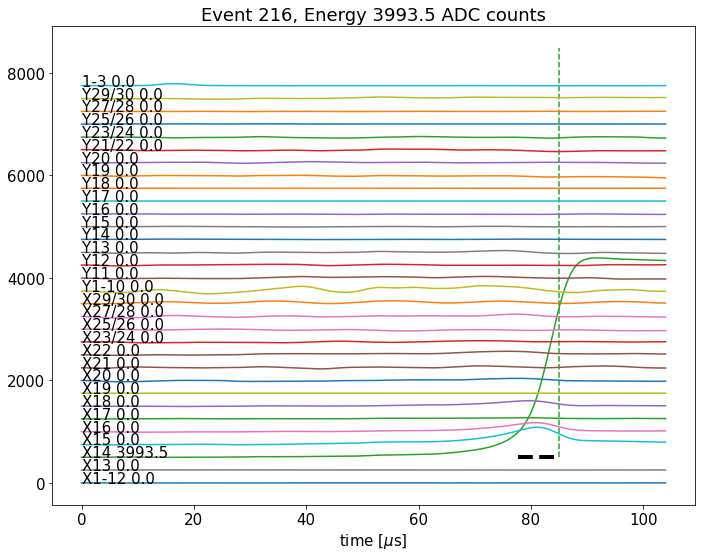

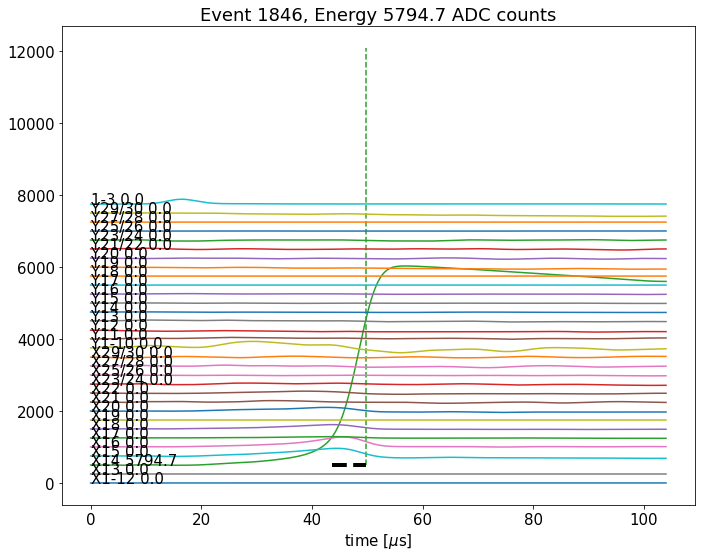

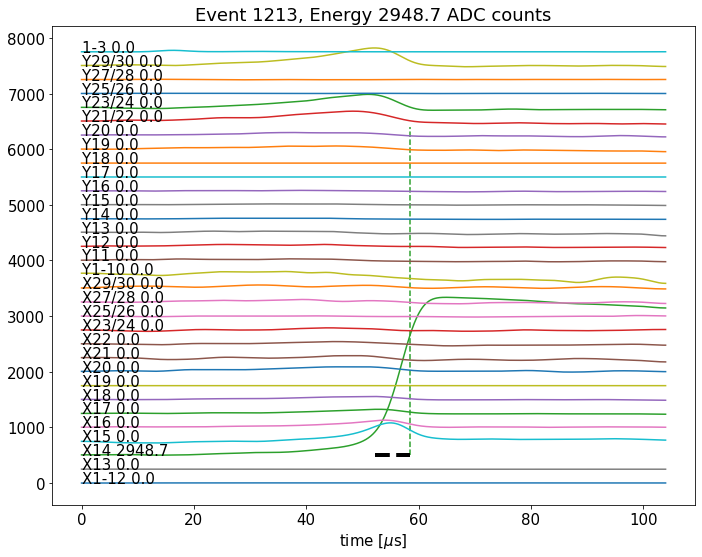

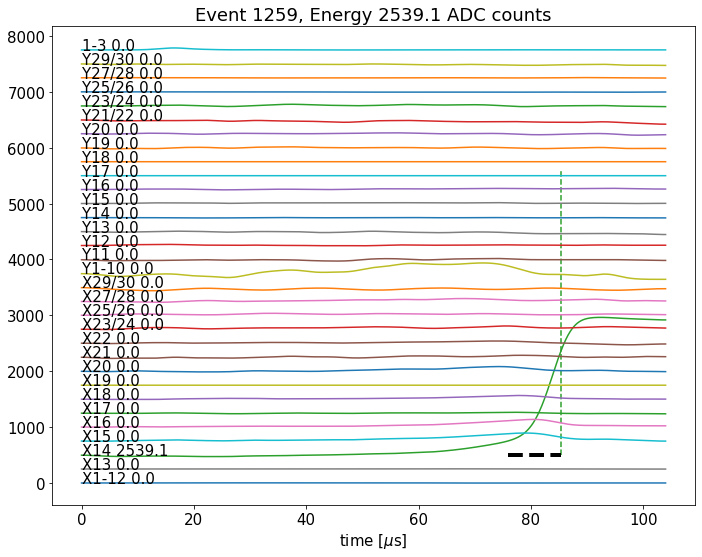

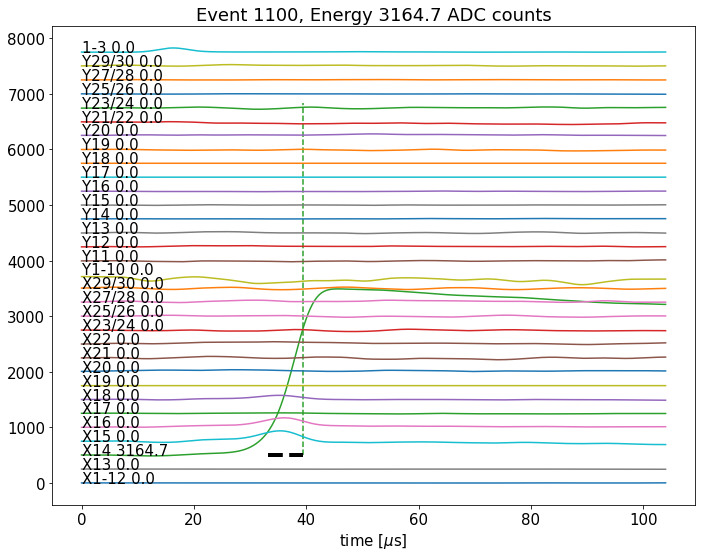

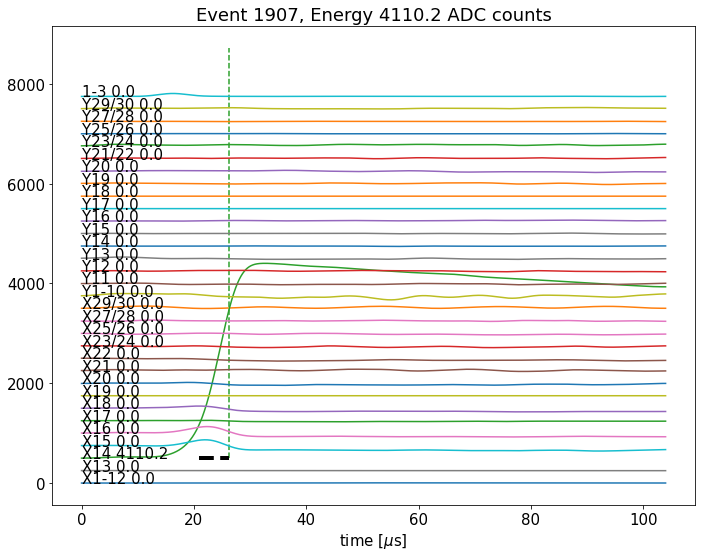

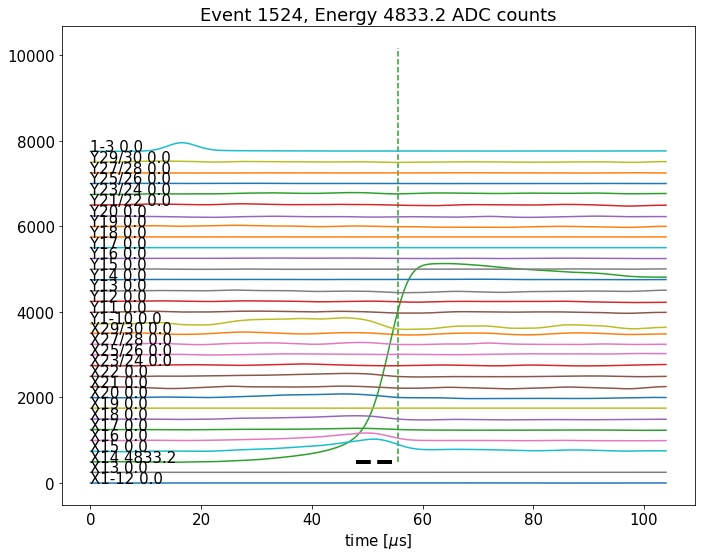

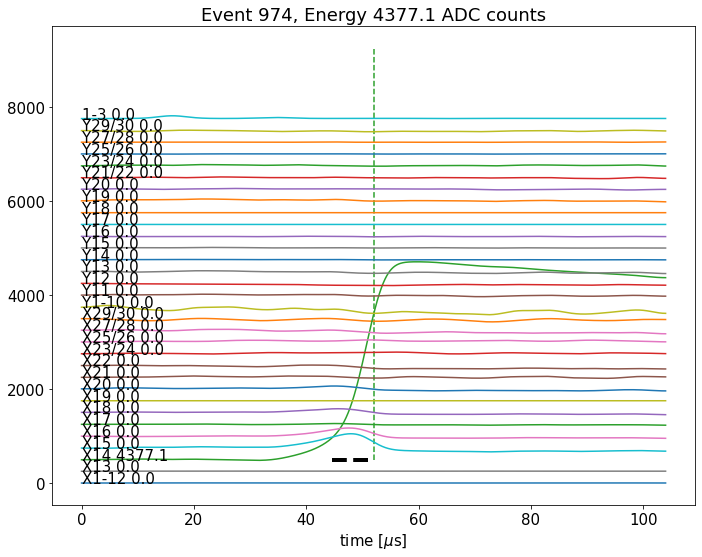

In [53]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/Channel_Map_Xe_Run29.csv'
for i in selection_index[:10]:
    event = Waveform.Event('/p/lustre1/jacopod/29th/analysis_500ns/{}/reduced_added.h5'.format(folder),\
                           '/p/lustre1/jacopod/29th/{}/tier1/'.format(folder),i,\
                       run_parameters_file,\
                       calibrations_file,\
                       channel_map_file)

    event.smooth(2.5)
    plot = event.plot_event(True)
    plot.hlines(500,df[ch + ' T10'].loc[[i]]*sampling_time,\
               (df[ch + ' T10'].loc[[i]]*sampling_time + rise_time10.loc[[i]]),linestyles='dashed',linewidths=4)
    plot.show()

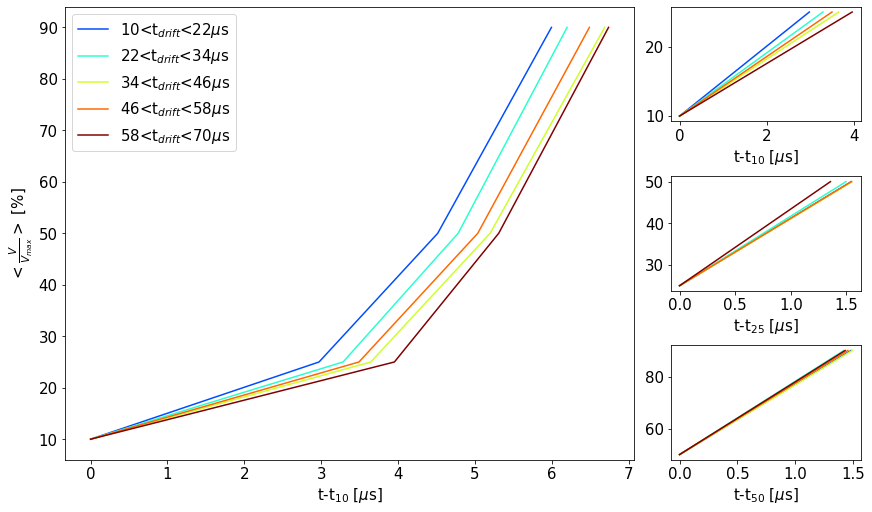

In [23]:
t_slice = 6
drift_range = np.linspace(min(ch_drift_time[mask_risetime]),max(ch_drift_time[mask_risetime]),t_slice)
fig3 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig3.add_gridspec(3, 4)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
f3_ax3 = fig3.add_subplot(gs[2, -1])
colors = plt.cm.jet(np.linspace(0,1,t_slice))
for j,dr in enumerate(drift_range):
    if j == 0:
        continue
    time_slice = np.logical_and(ch_drift_time[mask_risetime]>drift_range[j-1],ch_drift_time[mask_risetime]<dr)
    y_val = [10.0,25.0,50.0,90.0]
    x_val = [0]
    for v in (rise_time1025[mask_risetime][time_slice],\
              rise_time2550[mask_risetime][time_slice],\
              rise_time5090[mask_risetime][time_slice]):
        x_val.append(np.mean(v))
    f3_ax0.plot(np.cumsum(x_val),y_val,label='{:.0f}<t$_{{drift}}$<{:.0f}$\mu$s'.format(drift_range[j-1],dr),c=colors[j])
    f3_ax1.plot([0,x_val[1]],[10.0,25.0],c=colors[j])
    f3_ax2.plot([0,x_val[2]],[25.0,50.0],c=colors[j])
    f3_ax3.plot([0,x_val[3]],[50.0,90.0],c=colors[j])
f3_ax0.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax1.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax2.set_xlabel('t-t$_{25}$ [$\mu$s]')
f3_ax3.set_xlabel('t-t$_{50}$ [$\mu$s]')
f3_ax0.set_ylabel(r'$<\frac{V}{V_{max}}>$ [%]')
f3_ax0.legend()
plt.show()

In [96]:
selection_array = df[mask].index

selection cut: 1122 events
